# Model Ensembling
---

Model ensembling is a powerful technique to help reduce the generalization error in machine learning tasks. Ensembling entails pooling the predictions of many models together in order to make a better prediction as a whole. A good ensemble relies on diversity, where the constituent models should be as different and as accurate as possible. Hence, we look at combinations between the feed-forward neural network and recurrent neural networks, which arguably will have highly different hypothesis spaces based on their inputs and architectures.

The most straightforward way to combine models is to weight their predictions equally by averaging. Arguably, a better technique is to use a weighted average of the predictions and feed the inputs of the ensemble models to a new, separate model that learns how to combine them in an optimal way. We apply the latter of these methods, where we feed the predictions of the constituent models to a linear regression model that learns how to weight the respective models such that it minimizes the validation error. Specifically, we combine the predictions of the LSTM network and the feed-forward neural network (MLP) through a linear regression model.

In [10]:
import sys, os
ROOT_PATH = os.path.abspath(".").split("src")[0]
module_path = os.path.abspath(os.path.join(ROOT_PATH+"/src/utils/"))
if module_path not in sys.path:
    sys.path.append(module_path)

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import keras

from tabulate import tabulate
from tensorflow import set_random_seed
from sklearn.linear_model import LinearRegression

import functions as f
import dl_functions as dlf

SEED=100; np.random.seed(SEED); set_random_seed(SEED)

In [11]:
c, p = f.color_palette()
sns.set(context='paper', style='whitegrid', palette=np.array(p))
plt.style.use('file://' + ROOT_PATH + "src/utils/plotparams.rc")

In [12]:
df_train, df_valid, df_test = f.load_data()
stats, target_tags, feature_tags, ts, ts_train, ts_valid, ts_test = f.load_metadata(return_ts=True)

# split datasets into features and targets
x_train, y_train = f.split_dataset(df_train.values, delay=1)
x_valid, y_valid = f.split_dataset(df_valid.values, delay=1)
x_test, y_test = f.split_dataset(df_test.values, delay=1)

# metadata
target_tags = df_train.columns.values[:3]
feature_tags = df_train.columns.values[3:]
target_stds = stats.loc[target_tags,"Std"].values
target_means = stats.loc[target_tags,"Mean"].values

In [13]:
def evaluate_error(mean_preds, std_preds, unc_preds, y_true, target_stds=target_stds):
    """
    Will evaluate the MAE of a set of predictions and targets.
    
    :param preds: Matrix of predictions with shape (n_obs, n_target_variables)
    :param targets: Matrix of true targets with shape (n_obs, n_target_variables)
    :param target_stdevs: 1D vector of the standard deviations of the target variables.
    
    :return return_dict: A dictionary with the computed error variables. 
    """
    maes = f.MAE(y_true, mean_preds, vector=True)
    mses = f.MSE(y_true, mean_preds, vector=True)
    maes_unstd = maes * target_stds
    mses_unstd = mses * target_stds
    
    expected_mean = np.mean(mean_preds, axis=0)
    expected_std = np.mean(std_preds, axis=0)
    expected_unc = np.mean(unc_preds, axis=0)

    # summarize in dataframe
    indexes = ["FT", "TT", "PT"]
    cols = ["MAE (std)", "MSE (std)", "Exp. mean", "Exp. std", "Exp. uncertainty"]
    data = np.column_stack([maes, mses, expected_mean, expected_std, expected_unc])
    df = pd.DataFrame(data, index=indexes, columns=cols)
    df.loc["Avg"] = df.mean()
    
    str_table = tabulate(df, headers='keys', tablefmt='psql', floatfmt='.5f')

    return_dict = {
        'df': df,
        'str_table': str_table,
        'maes': maes,
        'mses': mses
    }

    return return_dict

In [14]:
def train_lm(lstm_model, mlp_model, x_data, y_data, n_pred=30):
    """
    Trains a linear model to predict targets given predictions of LSTM and MLP model. 
    """
    
    # Make predictions with the LSTM
    lstm_preds = dlf.predict_with_model(lstm_model, x_data, y_data, n_predictions=n_pred)[0]
    
    # Make predictions with the MLP 
    mlp_preds = dlf.predict_with_model(mlp_model, x_data, y_data, n_predictions=n_pred, input_dim=2)[0]
    
    # Concatenate the predictions to one dataset such that it can be read by another model
    X = np.concatenate((lstm_preds, mlp_preds), axis=1)
    
    # Find weights between the predictions of the LSTM model and the MLP by Linear Regression.
    lm = LinearRegression().fit(X,y_data)
    
    return lm
    
    
def evaluate_ensemble(lm, lstm_model, mlp_model, val_tuple, test_tuple, n_pred=30, model_mses=[]):
    
    print("\n **** VALIDATION **** ")
    val_preds, val_unc, val_stds, mses = dlf.predict_with_ensemble(linear_model, lstm_model, mlp_model, 
                                                         val_tuple[0], val_tuple[1], 
                                                         n_pred, 
                                                         return_stds=True, 
                                                         model_mses=model_mses)
    
    val_errs = evaluate_error(val_preds, val_stds, val_unc, val_tuple[1])
    print(val_errs['str_table'])
    
    print("\n **** TEST **** ")
    test_preds, test_unc, test_stds, mses = dlf.predict_with_ensemble(linear_model, lstm_model, mlp_model, 
                                                     test_tuple[0], test_tuple[1], 
                                                     n_pred, return_stds=True, 
                                                     model_mses=model_mses)
    
    test_errs = evaluate_error(test_preds, test_stds, test_unc, test_tuple[1])
    print(test_errs['str_table'])
    
    return val_errs, test_errs

#### Train a linear model
Train a linear model that takes the predictions of the LSTM and MLP as inputs. 
Using the predictions of the models on the validation data for this. 

In [15]:
n_pred=300

# load the LSTM and MLP model
lstm_model = dlf.load_keras_model(ROOT_PATH + "models/lstm_128/50/")
mlp_model = dlf.load_keras_model(ROOT_PATH + "models/mlp_1024/50/")

# train a linear model on validation data
linear_model = train_lm(lstm_model, mlp_model, x_valid, y_valid, n_pred)

#### Evaluating the ensemble

In [ ]:
val_eval, test_eval = evaluate_ensemble(linear_model, lstm_model, mlp_model,
                                         (x_valid, y_valid),
                                         (x_test, y_test),
                                         n_pred=n_pred)


 **** VALIDATION **** 
+-----+-------------+-------------+-------------+------------+--------------------+
|     |   MAE (std) |   MSE (std) |   Exp. mean |   Exp. std |   Exp. uncertainty |
|-----+-------------+-------------+-------------+------------+--------------------|
| FT  |     0.58136 |     0.59529 |    -0.24922 |    0.18677 |            0.79548 |
| TT  |     0.25281 |     0.09635 |     1.33700 |    0.14624 |            0.34572 |
| PT  |     0.40383 |     0.27548 |    -0.00123 |    0.17721 |            0.55576 |
| Avg |     0.41266 |     0.32237 |     0.36218 |    0.17007 |            0.56565 |
+-----+-------------+-------------+-------------+------------+--------------------+

 **** TEST **** 


#### Export results

In [ ]:
ensemble_dict = {
    "validation": val_eval,
    "test": test_eval
}

# Error summary
dicts = [ensemble_dict]
columns=["FT", "TT", "PT", "Avg"]
index = ["LSTM/MLP"]
summary, tex = dlf.get_df_from_dicts(dicts, columns, index)

# Uncertainty summary
val_unc_df = val_eval['df'].round(4)
val_unc_df.columns=["MAE", "MSE", "Mean", "Std", 'Uncertainty']

test_unc_df = test_eval['df'].round(4)
test_unc_df.columns=val_unc_df.columns

ensemble_unc = pd.concat([val_unc_df, test_unc_df], axis=1, keys=["Validation", "Test"])
ensemble_unc

In [ ]:
path = ROOT_PATH + "models/dataframes/"
summary.to_pickle(path + "ensemble_summary_df.pkl")
ensemble_unc.to_pickle(path + "ensemble_uncertainty_df.pkl")

In [ ]:
f.save_pickle(linear_model, ROOT_PATH + "models/ensemble/linear_model.pkl")
lstm_model.save(ROOT_PATH + "models/ensemble/lstm_model.h5")
mlp_model.save(ROOT_PATH + "models/ensemble/mlp_model.h5")

### Example

#### Load the models

In [ ]:
# load models
lstm = keras.models.load_model(ROOT_PATH + "models/ensemble/lstm_model.h5")
mlp = keras.models.load_model(ROOT_PATH + "models/ensemble/mlp_model.h5")
lm = f.load_pickle(ROOT_PATH + "models/ensemble/linear_model.pkl")

In [18]:
n_pred = 300
mean_preds, unc_preds, pred_matr = dlf.predict_with_ensemble(lm, lstm, mlp, 
                                                             x_test, y_test, 
                                                             n_pred=n_pred, 
                                                             return_predictions_matrix=True)

#### Plot the distribution of a single point prediction

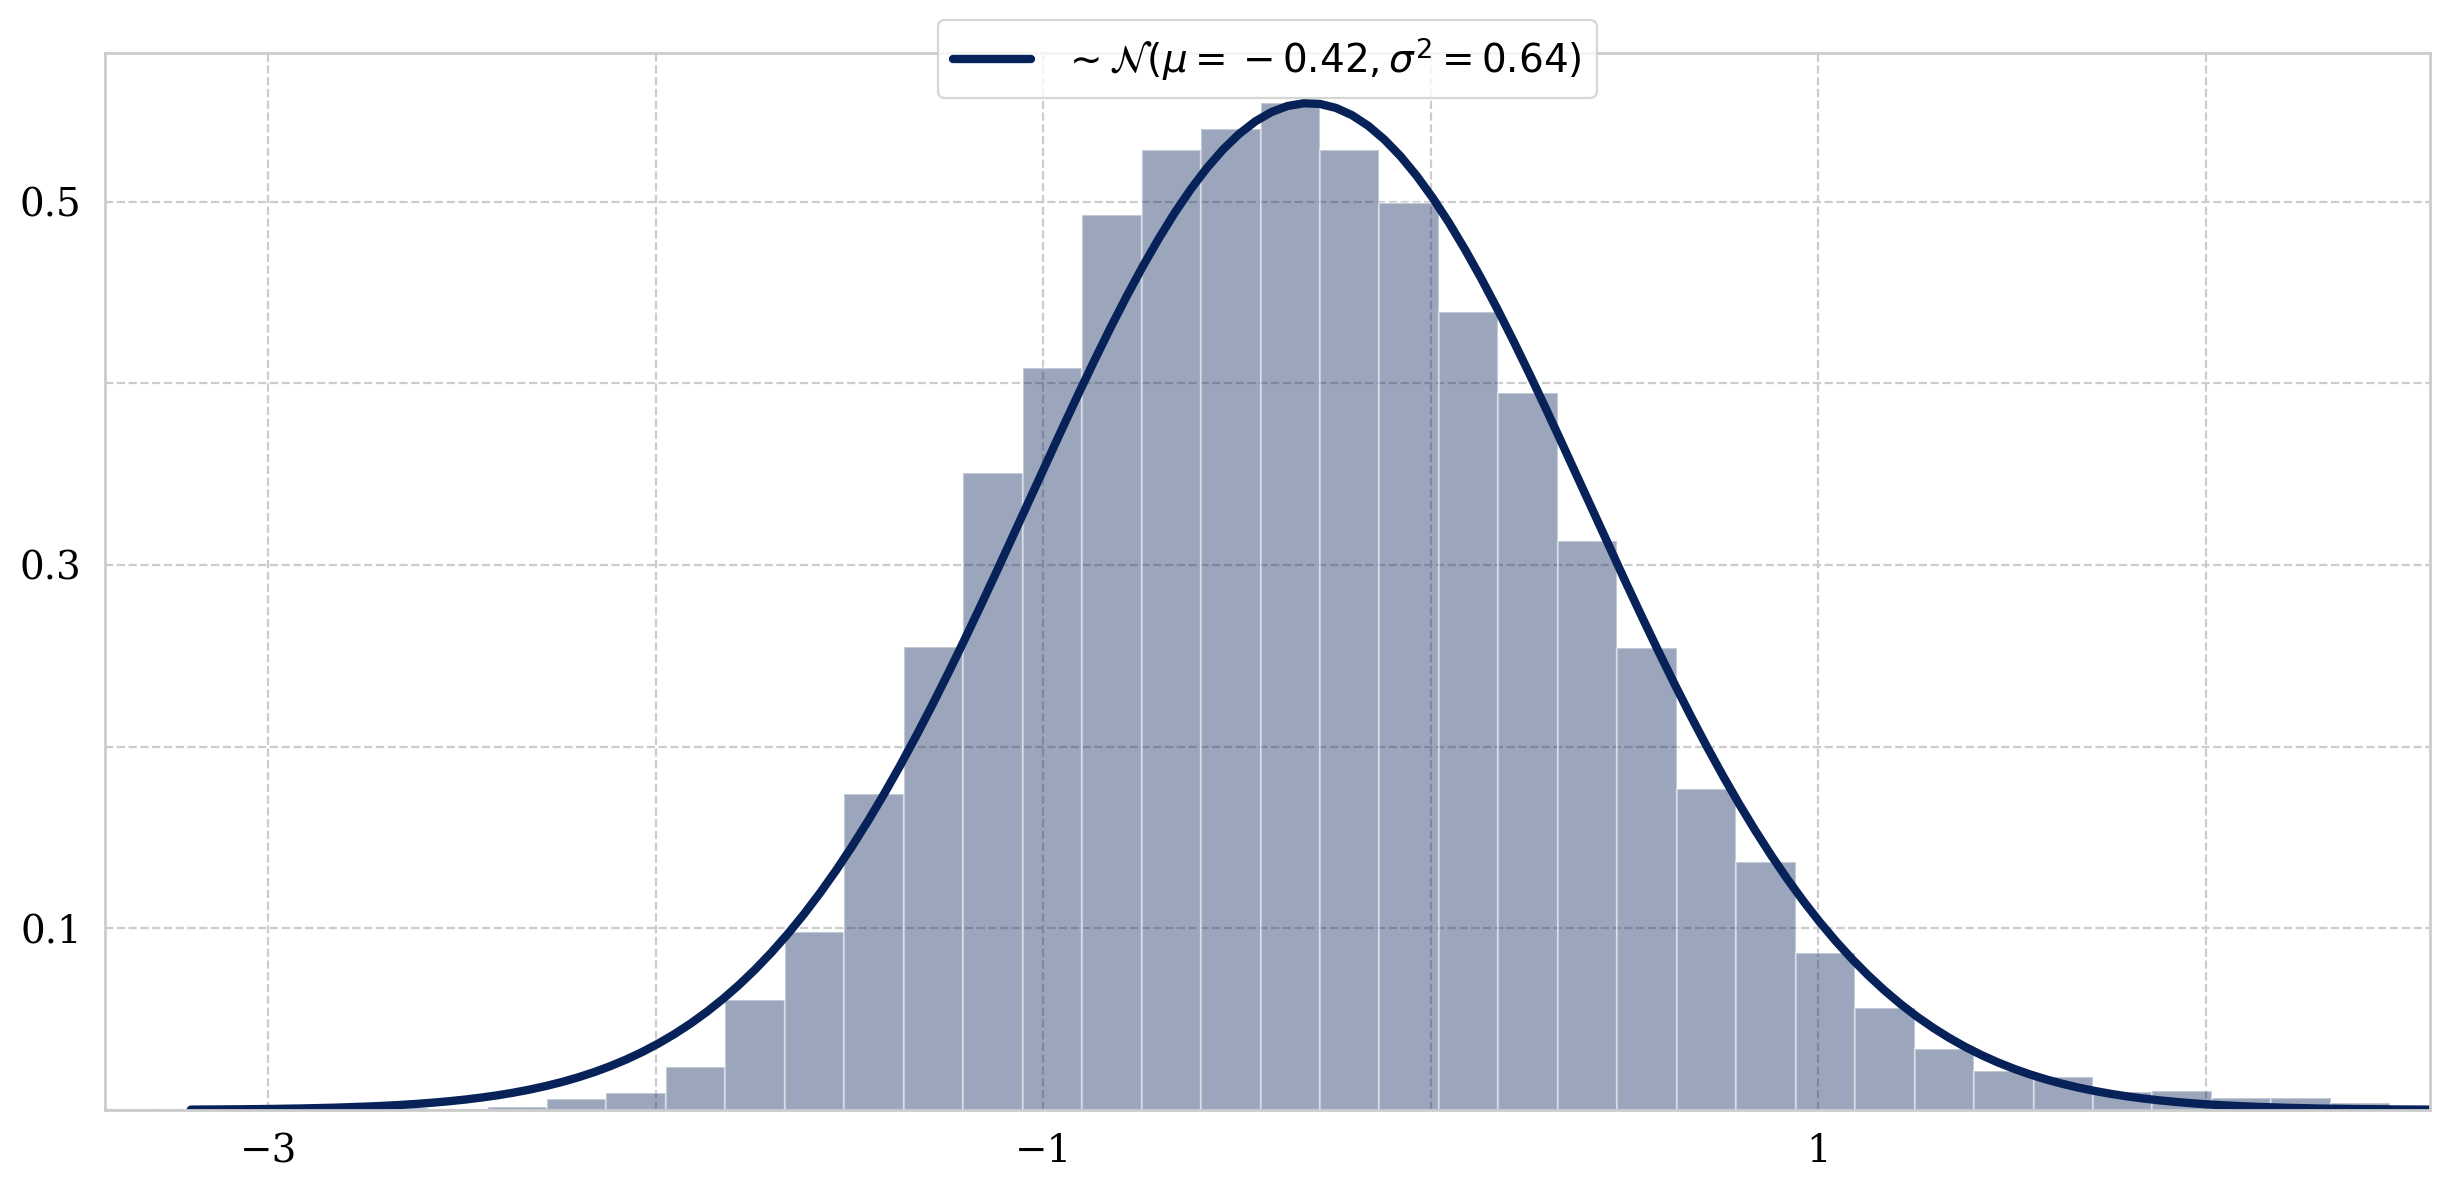

In [19]:
from scipy.stats import norm
signal = 0
run = 0

mean_pred = mean_preds[run,signal]
unc_pred = unc_preds[run,signal]
preds = pred_matr[run,:,signal]

fig, ax = plt.subplots(figsize=(15,7))
sns.distplot(preds, ax=ax, fit=norm, kde=False,
             fit_kws={"lw":3, 
                      "color":c["blue_dark"], 
                      "label":r'$ \sim {0}(\mu={1}, \sigma^2={2})$'.format("\mathcal{N}", 
                                                                round(mean_pred,2), 
                                                                round(unc_pred**2,2))},
            #hist_kws={"alpha": 1}
            )
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=False)
ax.set_xlim((mean_pred-3,mean_pred+3))

for label in ax.get_yticklabels()[::2]:
    label.set_visible(False)
    
for label in ax.get_xticklabels()[::2]:
    label.set_visible(False)


fig.show()

In [20]:
from scipy.stats import shapiro
shapiro(preds)

/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9819595217704773, 4.805052434169798e-42)

#### Make predictions and plot sample

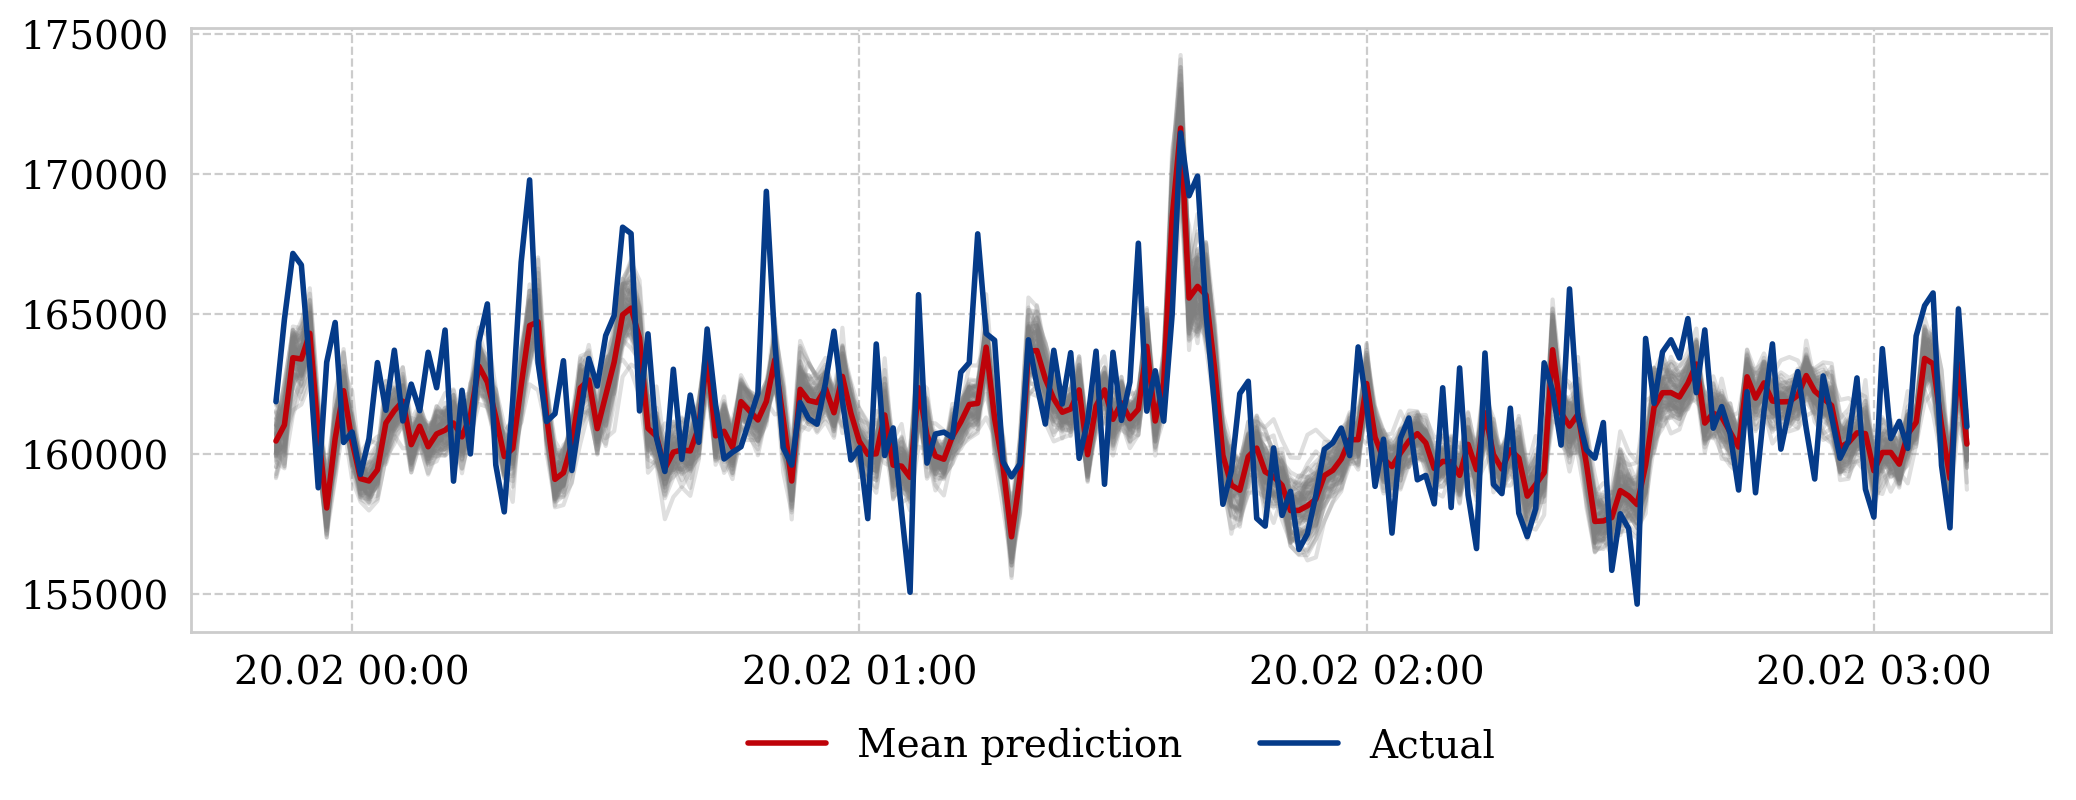

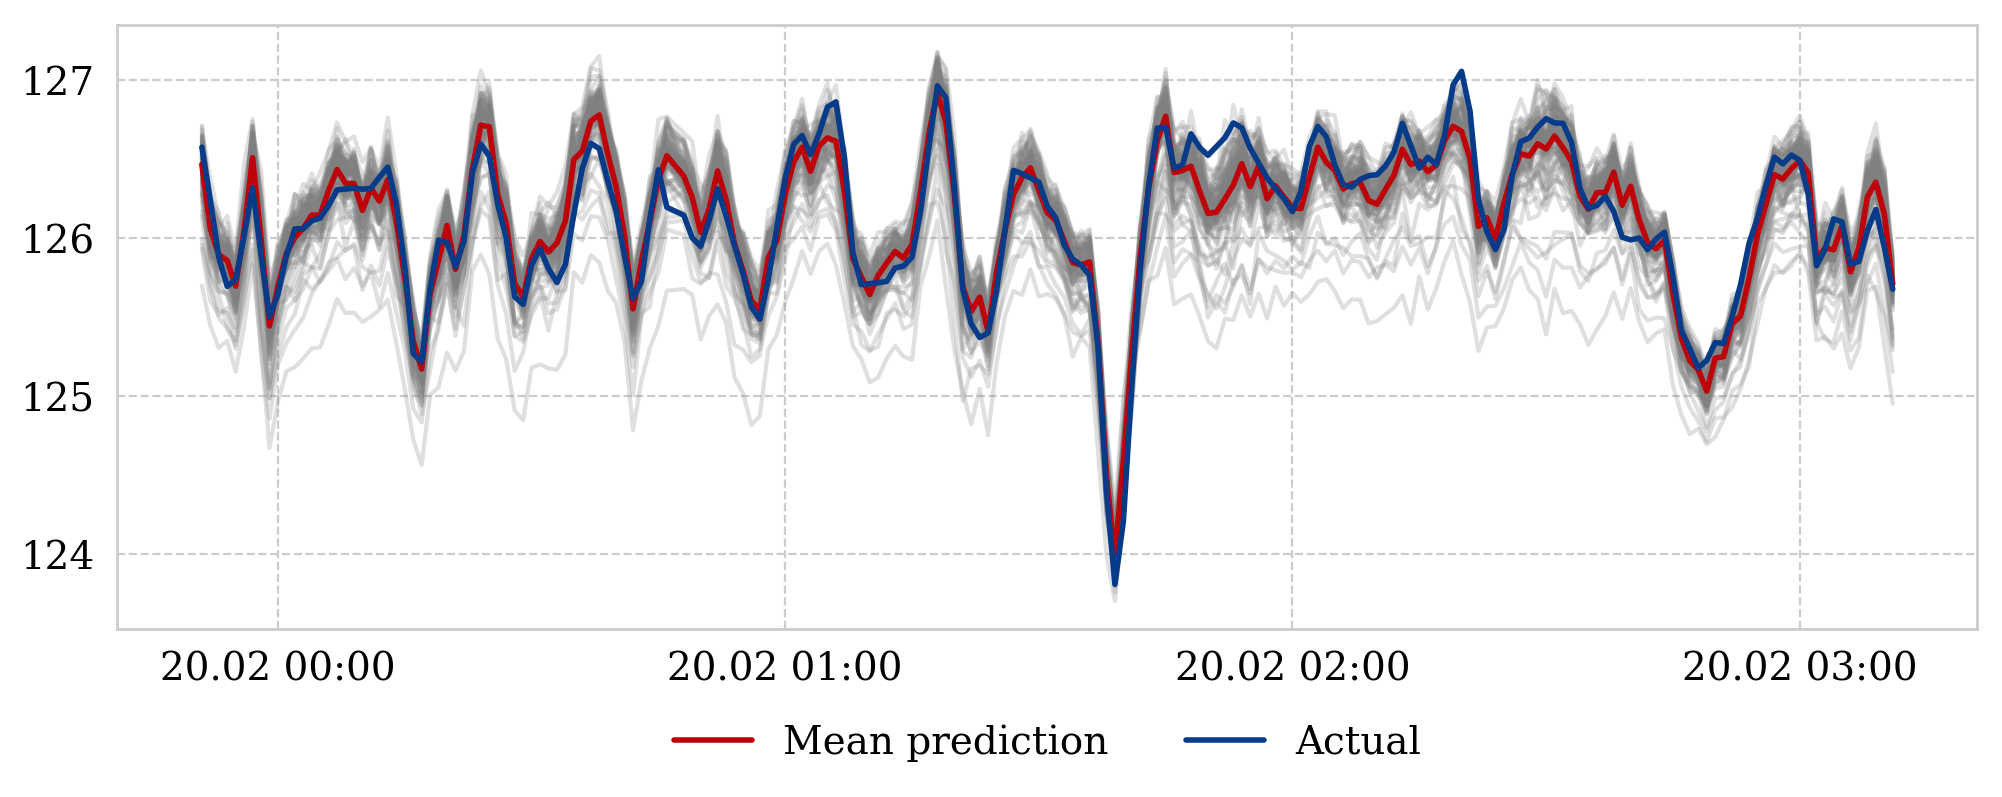

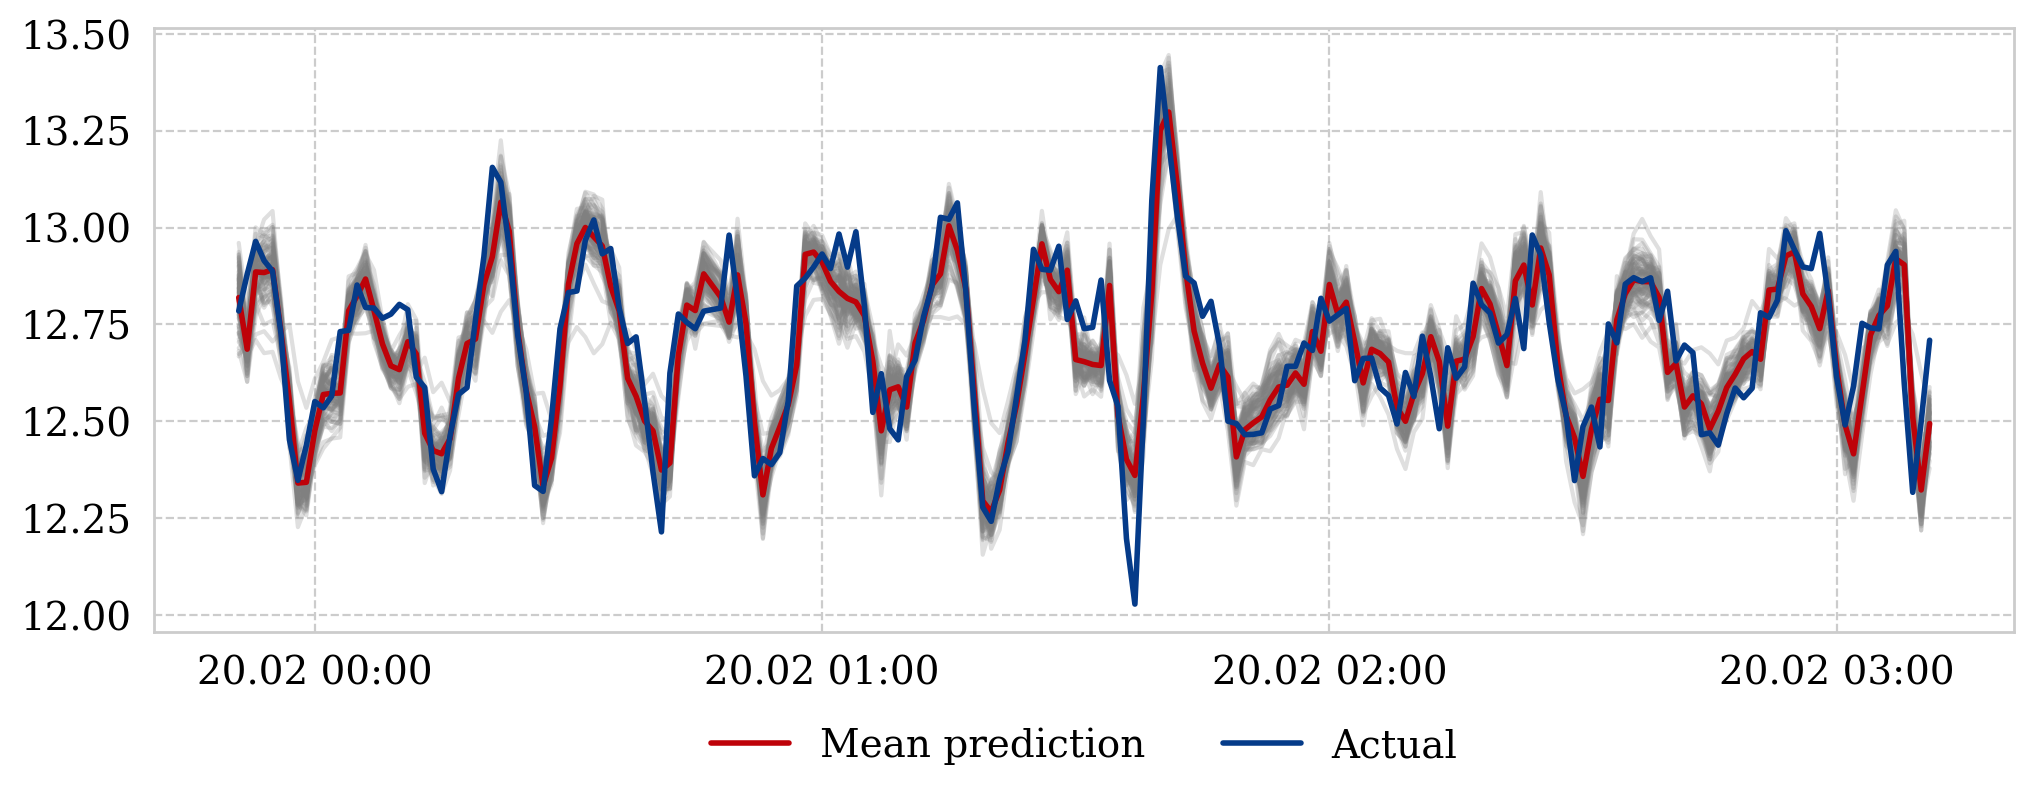

In [21]:
dlf.plot_pred_matrix(pred_matr*target_stds+target_means, 
                     unc_preds*target_stds, 
                     y_test*target_stds+target_means, 
                     ts_test, 
                     ["Discharge flow", "Discharge temperature", "Discharge pressure"],
                     start_idx=11970, n_obs=200, plotCI=False, z=3.1)